## Task 1 - Climate Feedback Parameter

The temporal evolution of surface temperature change $\Delta T_s$ in response to a climate forcing $ERF$ can be expressed as follows:

$$
\Delta T_s(t) = \frac{ERF}{\lambda}\left[exp\left(\frac{\lambda}{C}t\right)-1\right]
$$

where $\lambda$ is the climate feedback parameter and $C$ the heat capacity of the ocean mixed layer, which we assume to have a thickness of $100m$. Evaluate the temporal evolution of $\Delta T_s$ when modifying $\lambda$ in sign and magnitude. 

Assume $ERF = 4\frac{W}{m^2}$ (~ present-day ERF) and the specific heat capacity of water $c=4182 \frac{J}{kg K}$ and assume only the temperature of the ocean mixed-layer to change. As $ERF$ is normalised to $1m^2$, only calculate $C$ for the same area.

**Important**: For all tasks, do not just present your results but interpret them!

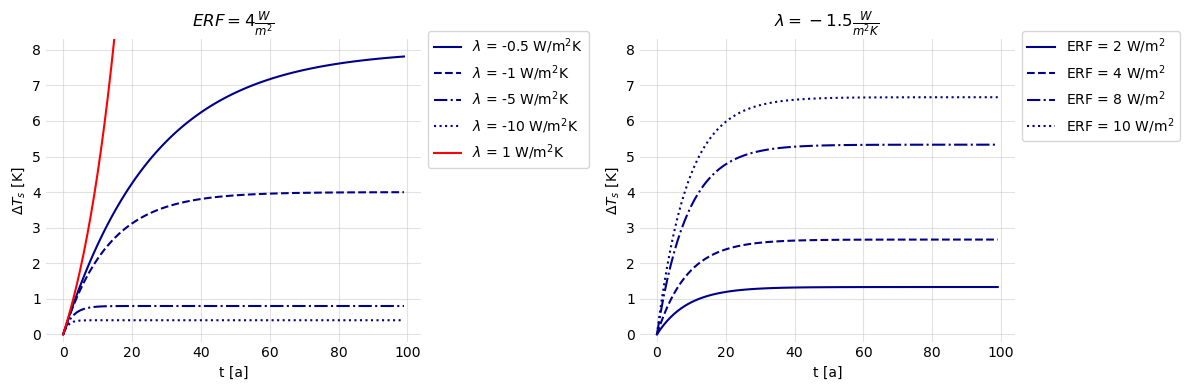

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-muted')

def delta_t(t, C, lamb=-1.5, ERF=4):
    """
    Distribution of the temperature difference compared to pre-industrial
    GHG conditions
    
    Arguments:
        t (array): time in years
        C (float): heat capacity in J/K
        lamb (float): climate feedback parameter in W/(m^2K)
                      Default -1.5W/(m^2K) roughly the current estimated 
                      climate feedback parameter
        ERF  (float): Effective radiative flux in W/m^2
                      Default 4W/m^2 present-day ERF normalised to 1m^2
        
    Returns:
        mean surface temperature change compared to climate without 
        antropoenic influence on the climate
    """
    seconds_per_year = 365*24*60*60                                         # calucalte the seconds per year to convert 
                                                                            # time from years to seconds
    return ERF/lamb*(np.exp(lamb*(t*seconds_per_year)/C)-1)

# -- calculate heat capacity of water in 1m^2x100m column
c = 4182                                                                    # specific heat capacity of water [J/(kg*K)]
V = 100                                                                     # volume of 100m high column of water
                                                                            # (1m^2) [m^3]
m = V*997                                                                   # mass of column of water 
                                                                            # (denstiy of water 997kg/m^3)
C = c*m                                                                     # heat capacity of column of water [J/K]

# -- plotting
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].set_title(r"$ERF = 4\frac{W}{m^2}$")
ax[0].set_xlabel("t [a]")
ax[0].set_ylabel("$\Delta T_s$ [K]")
ax[0].set_ylim([-0.2,8.3])
ax[1].set_title(r"$\lambda = -1.5 \frac{W}{m^2 K}$")
ax[1].set_xlabel("t [a]")
ax[1].set_ylabel("$\Delta T_s$ [K]")
ax[1].set_ylim([-0.2,8.3])

colors = ["darkblue", "darkblue", "darkblue", "darkblue", "red"]
linestyles = ["solid", "--", "-.", ":", "solid"]

for idx, lamb in enumerate([-0.5,-1,-5,-10,1]):                                          # plot for different climate feedback
    ax[0].plot(np.arange(0,100), delta_t(np.arange(0,100), C,               # parameters
               lamb=lamb), label=f"$\lambda$ = {lamb} W/m$^2$K",
              linestyle=linestyles[idx], color=colors[idx])
    
for idx, ERF in enumerate([2,4,8,10]):                                                      # plot for different effective radiative 
    ax[1].plot(np.arange(0,100), delta_t(np.arange(0,100), C,               # forcings
               ERF=ERF), label=f"ERF = {ERF} W/m$^2$", 
              linestyle=linestyles[idx], color=colors[idx])
    
ax[0].legend(bbox_to_anchor=(1, 1.05))
ax[1].legend(bbox_to_anchor=(1, 1.05))

# add grids
ax[0].grid(which='major', color='#C8C6C6', linewidth=0.8)
ax[1].grid(which='major', color='#C8C6C6', linewidth=0.8)
# remove spines for better readibility
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)
# adjust ticks
ax[0].tick_params(direction='out', length=0, width=2, colors='black',
                  grid_color='#C8C6C6', grid_alpha=0.5)
ax[1].tick_params(direction='out', length=0, width=2, colors='black',
                  grid_color='#C8C6C6', grid_alpha=0.5) 
plt.tight_layout()

plt.savefig("plots/Task1_surface_temperature_change.png", dpi=300)

## Task 2

Perform a Gregory analysis on the output of the MPI-ESM climate model. In the data directory, you will find model data necessary for this analysis.

You will make use of two experiments, the so-called *piControl* experiment where greenhouse gas  concentration is representative for preindustrial conditions, and the *abrupt-4xCO2* experiment,  here, starting from the piControl simulations, the amount of $CO_2$ in the atmosphere is abruptly quadrupled. This strong increase is necessary to make the radiative forcing due to $CO_2$ and resulting effects large compared to internal variability.

For the Gregory analysis, you need to derive $\Delta R$ and $\Delta T_s$ between *abrupt-4xCO2*  and *piControl*. Create a scatter plot of the timeseries of $\Delta R$ and $\Delta T_s$ and fit a linear regression to these datapoints to derive $\lambda$ (slope) and $ERF$ (y-intercept). Data for this analysis have already been preprocessed, which you can find in the data directory (i.e. *MPI-ESM1-2-LR_abrupt-4xCO2_yearmean_globalmean.nc* and *MPI-ESM1-2-LR_piControl_timmean_globalmean.nc*)

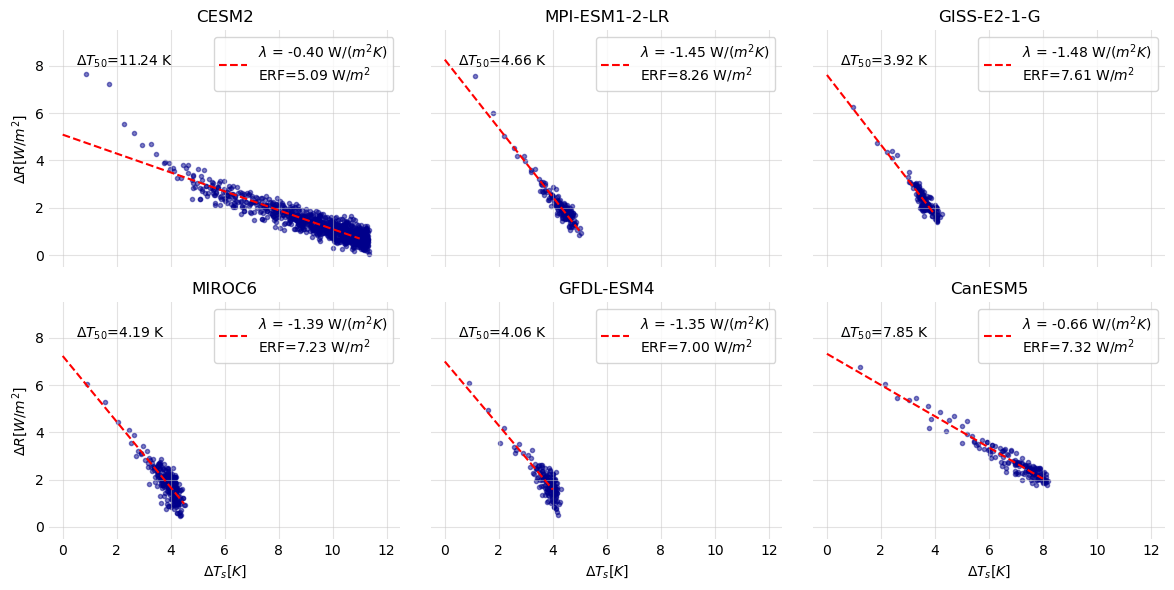

In [2]:
import xarray as xr                                                   
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

model_list = os.listdir("data_feedback/")                               # load list of model names

# -- create figure for plots
fig, ax = plt.subplots(2,int(len(model_list)/2), figsize=(12,6), 
                       sharex=True, sharey=True)  
axflat = ax.flatten()                                                   # flatten axes for easier plotting

for idx, model in enumerate(model_list):                                # loop over all available models
    
    ds1 = xr.open_dataset(f"data_feedback/{model}/{model}_abrupt-"    +\
                          "4xCO2_yearmean_globalmean.nc").squeeze()     # load abrupt-4xC02 experiment
    ds2 = xr.open_dataset(f"data_feedback/{model}/{model}_piControl"  +\
                          "_timmean_globalmean.nc").squeeze()           # load preindustrial control experiment
    
    Delta_T = ds1.ts - ds2.ts.data                                      # caluclate temperature difference
    dT_mean = Delta_T.values[-50:].mean()                               # caluclate mean temperature of last 50 years

    R       = ds1.rsdt - ds1.rsut - ds1.rlut                            # caluclate top-of-atmosphere energy budget
    R_cntrl = ds2.rsdt - ds2.rsut - ds2.rlut                            # for both runs

    Delta_R = R - R_cntrl                                               # calculate difference in energy budget

    axflat[idx].scatter(Delta_T, Delta_R, c="darkblue", alpha=0.5,      # plot data points
                        marker=".")
    
    lamb, ERF = np.polyfit(Delta_T, Delta_R, 1)                         # fit data
    T         = np.arange(0,np.max(Delta_T),0.5)
    axflat[idx].plot(T, lamb*T+ERF, c='red', linestyle="dashed", 
                     label=f"$\lambda$ = {lamb:.2f} W/($m^2K$)\n" +\
                     f"ERF={ERF:.2f} W/$m^2$") 
    axflat[idx].text(0.5, 8, r"$\Delta T_{50}$"+f"={dT_mean:.2f} K")
    
    axflat[idx].set_title(model)                                        # set title for plot
    if idx == 0 or idx == 3:                                            # set ylabel for left plots
        axflat[idx].set_ylabel("$\Delta R [W/m^2]$")
    if idx > 2: 
        axflat[idx].set_xlabel("$\Delta T_s [K]$")                      # set xlabel for bottom plots
    axflat[idx].set_ylim(-0.5,9.5)
    axflat[idx].set_xlim(-0.5,12.5)

    axflat[idx].legend()
    axflat[idx].grid(which='major', color='#C8C6C6', linewidth=0.8)     # add grids
    axflat[idx].spines['top'].set_visible(False)                        # remove spines for better readibility
    axflat[idx].spines['right'].set_visible(False)
    axflat[idx].spines['bottom'].set_visible(False)
    axflat[idx].spines['left'].set_visible(False)
    axflat[idx].tick_params(direction='out', length=0, width=2,         # adjust ticks
                            colors='black', grid_color='#C8C6C6', 
                            grid_alpha=0.5)
plt.tight_layout()

plt.savefig("plots/Task2_gegory_method.png", dpi=300)

## Task 3

Determine the spatially resolved ERF from simulations where sea surface temperature
and sea ice concentration is fixed to their preindustrial conditions and quadrupled CO2
concentration (piClim-4xCO2), determining the difference to piControl
simulations.Both the piClim-4xCO2 and piControl datasets have already been
temporally averaged.
Using the derived ERF, calculate the spatially resolved climate feedback parameter λ,
which can than be derived as follows:
∆Rabrupt-4xCO2 − ERF
λ =
 (2)
Ts,abrupt-4xCO2 − Ts,piClim-4xCO2
Compare the global mean, temporal averaged ERF and λ to those derived from the
Gregory analysis. Files for this task will all end with *ymonmean.nc.

MPI-ESM1-2-LR: lambda = -1.602 W/(m^2K), ERF = 9.056 W/m^2
GFDL-ESM4: lambda = -1.978 W/(m^2K), ERF = 9.538 W/m^2
GISS-E2-1-G: lambda = -1.387 W/(m^2K), ERF = 7.343 W/m^2
CanESM5: lambda = -0.726 W/(m^2K), ERF = 7.952 W/m^2
MIROC6: lambda = -1.362 W/(m^2K), ERF = 7.186 W/m^2
CESM2: lambda = -1.036 W/(m^2K), ERF = 9.527 W/m^2


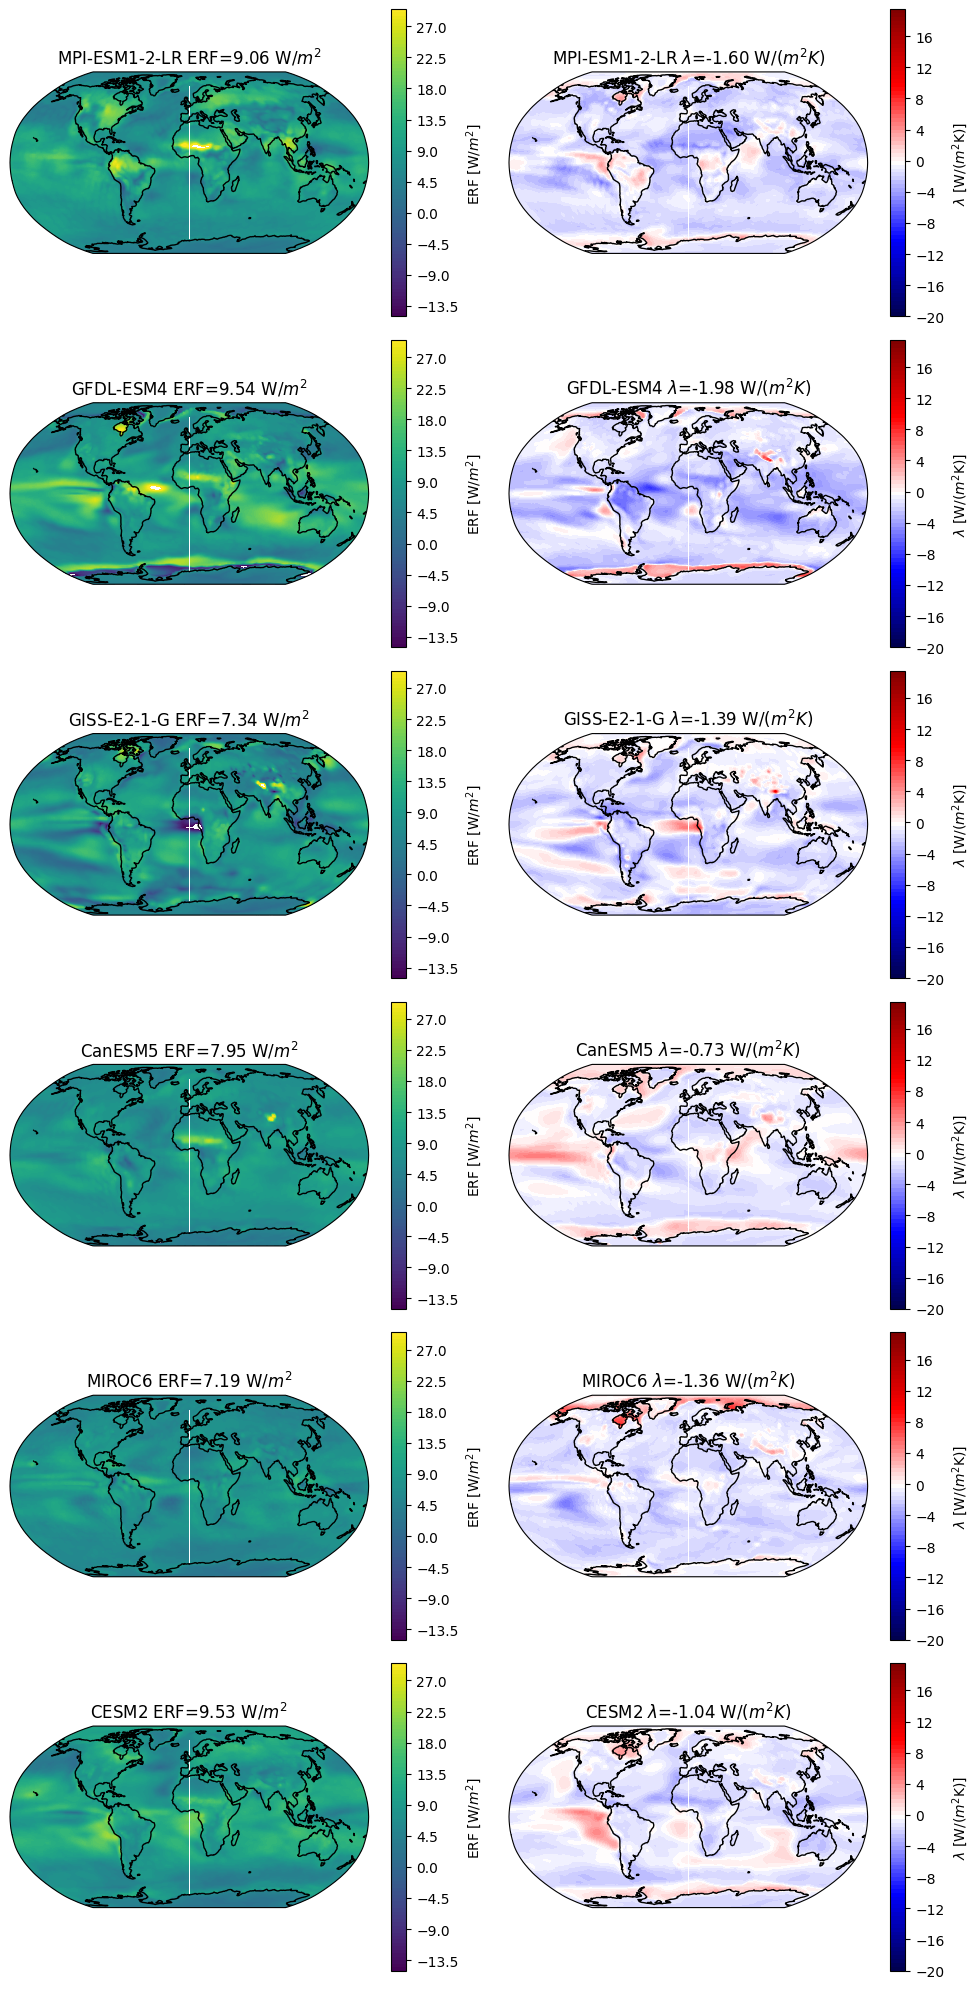

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import warnings
warnings.filterwarnings("ignore")
                                                                        
archive = "data_feedback/"                                              # define archive with files with model data
model_list = os.listdir("data_feedback/")                               # load list of all available models
times = np.arange(1,13)                                                 # create times array to reassign coordinates

fig, ax = plt.subplots(int(len(model_list)), 2,                         # define figure with cartopy
          subplot_kw={'projection': ccrs.Robinson()}, figsize=(10,20))

for idx, model in enumerate(model_list):                                # loop over all models
    
    ds_picntrl = xr.open_dataset(f"{archive}{model}/{model}_"         +\
                                 "piControl_ymonmean.nc",               # load data from file for all models
                                 decode_times=False).assign_coords(     # and assign times as new coordinates
                                 time=times)                            # to make them comparable
    ds_piclim  = xr.open_dataset(f"{archive}{model}/{model}_piClim-"  +\
                                 "4xCO2_ymonmean.nc", 
                                 decode_times=False).assign_coords(
                                 time=times)
    ds_abrpt   = xr.open_dataset(f"{archive}{model}/{model}_abrupt-"  +\
                                 "4xCO2_ymonmean.nc", 
                                 decode_times=False).assign_coords(
                                 time=times)

    R_picntrl = ds_picntrl.rsdt - ds_picntrl.rsut - ds_picntrl.rlut     # calculate top-of-atmosphere radiation
    R_piclim  = ds_piclim.rsdt  - ds_piclim.rsut  - ds_piclim.rlut      # for control, 4xCO2 with fixed SST and
    R_abrpt   = ds_abrpt.rsdt   - ds_abrpt.rsut   - ds_abrpt.rlut       # 4xCO2 runs

    ERF = R_piclim - R_picntrl
    ERF_yr = ERF.mean(dim="time")
    Delta_R = R_abrpt - R_picntrl

    # global averaging
    
    
    weights = np.cos(np.deg2rad(ds_picntrl.lat))
    Delta_Ts = (ds_abrpt.ts - ds_picntrl.ts).weighted(weights).mean(dim={"lat", "lon"})
    lamb = (Delta_R - ERF)/Delta_Ts
    lamb_yr = lamb.mean(dim="time")
    
    # global averaging
    lamb_glmean = lamb_yr.weighted(weights).mean(dim={"lat", "lon"})
    ERF_glmean = ERF_yr.weighted(weights).mean(dim={"lat", "lon"})
    print(f"{model}: lambda = {lamb_glmean.values:.3f} W/(m^2K), ERF = {ERF_glmean.values:.3f} W/m^2")
    
    #ax[idx].title(model)
    ax[idx,0].set_title(f"{model} ERF={ERF_glmean.values:.2f} W/$m^2$")
    ax[idx,1].set_title(f"{model} $\lambda$={lamb_glmean.values:.2f} W/$(m^2K)$")
    ax[idx,0].coastlines()
    ax[idx,1].coastlines()
    
    im_ERF = ax[idx,0].contourf(ERF_yr.lon, ERF_yr.lat, ERF_yr, transform=ccrs.PlateCarree(), levels=np.arange(-15,30,0.5))
    im_lamb = ax[idx,1].contourf(lamb_yr.lon, lamb_yr.lat, lamb_yr, cmap="seismic", transform=ccrs.PlateCarree(), levels=np.arange(-20,20, 0.5))
    
    plt.colorbar(im_ERF,ax=ax[idx,0], label="ERF [W/$m^2$]")
    plt.colorbar(im_lamb,ax=ax[idx,1], label="$\lambda$ [W/($m^2$K)]")

plt.tight_layout()


## Task 4

Use the radiative kernels to separate the total climate feedback into the albedo, Planck,
lapse-rate and water vapor feedback.
You can find the radiative kernels in the radiative kernel directory. Plot the respective
feedbacks on global maps. Start with the MPI-ESM but prepare analysis structure for
multiple models.
Expand the feedback analysis to the other CMIP6 models provided. Plot the multi-model
mean feedbacks on global maps.

In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import warnings
warnings.filterwarnings("ignore")
                  
filename = 'radiative_kernel/HadGEM3-GA7.1_TOA_kernel_L19.nc'
ds_krnl = xr.open_dataset(filename).rename({'month': 'time'})

In [5]:
archive = "data_feedback/"                                              # define archive with files with model data
model_list = os.listdir("data_feedback/")                               # load list of all available models
times = np.arange(1,13)                                                 # create times array to reassign coordinates


# create empty lists to append
lambda_total = []
lambda_A = []
lambda_WV = []
lambda_LR = []
lambda_P = []
lambda_C = []

for idx, model in enumerate(model_list):                                # loop over all models

    ds_picntrl = xr.open_dataset(f"{archive}{model}/{model}_"         +\
                                     "piControl_ymonmean.nc",               # load data from file for all models
                                     decode_times=False).assign_coords(     # and assign times as new coordinates
                                     time=times)                            # to make them comparable
    ds_piclim  = xr.open_dataset(f"{archive}{model}/{model}_piClim-"  +\
                                     "4xCO2_ymonmean.nc", 
                                     decode_times=False).assign_coords(
                                     time=times)
    ds_abrpt   = xr.open_dataset(f"{archive}{model}/{model}_abrupt-"  +\
                                     "4xCO2_ymonmean.nc", 
                                     decode_times=False).assign_coords(
                                     time=times)

    R_picntrl = ds_picntrl.rsdt - ds_picntrl.rsut - ds_picntrl.rlut     # calculate top-of-atmosphere radiation
    R_piclim  = ds_piclim.rsdt  - ds_piclim.rsut  - ds_piclim.rlut      # for control, 4xCO2 with fixed SST and
    R_abrpt   = ds_abrpt.rsdt   - ds_abrpt.rsut   - ds_abrpt.rlut       # 4xCO2 runs

    # -- total feedback
    ERF = R_piclim - R_picntrl
    ERF_yr = ERF.mean(dim="time")
    Delta_R = R_abrpt - R_picntrl

    weights = np.cos(np.deg2rad(ds_picntrl.lat))
    Delta_Ts = (ds_abrpt.ts - ds_picntrl.ts).weighted(weights).mean(dim={"lat", "lon"})
    lambda_total.append((Delta_R - ERF)/Delta_Ts)

    # -- Albedo feedback
    toa_sw_out = ds_picntrl['rsutcs']
    toa_sw_in = ds_picntrl['rsdt']
    a_picntrl = toa_sw_out/toa_sw_in

    toa_sw_out = ds_abrpt['rsutcs']
    toa_sw_in = ds_abrpt['rsdt']
    a_abrpt = toa_sw_out/toa_sw_in

    Da = 100*(a_abrpt-a_picntrl)
    K_a = ds_krnl['K_a']
    DR_A = K_a*Da
    lambda_A.append(DR_A/Delta_Ts)

    # -- difference between te pressure levels
    plev = np.array(ds_krnl['p'])
    dp = np.diff(plev, axis=1, append=0)
    pstrat = 100*10**2+200*10**2* np.abs(ds_picntrl.lat)/90  # tropopause pressure mask
    pstrat_mask = np.broadcast_to(pstrat.values[np.newaxis,np.newaxis,:,np.newaxis], dp.shape) # reshape to fit
    dp_mask = np.where(plev>=pstrat_mask, dp, 0)
    dp_mask = - dp_mask/10000 # convert to 100hPa unit to match K unit (add minus b/c K is defined from toa)

    # -- temperature feedback
    K_Ts = ds_krnl['K_T_sfc']
    K_T = ds_krnl['K_T']
    D_Ts = ds_abrpt.ts - ds_picntrl.ts
    D_Ti = ds_abrpt.ta - ds_picntrl.ta
    DR_T = K_Ts*D_Ts + np.sum(K_T * D_Ti *dp_mask, axis=1)
    lambda_T = DR_T/Delta_Ts

    # -- Planck feedback
    DR_P = (K_Ts + np.sum(K_T * dp_mask, axis=1))*D_Ts
    lambda_P.append(DR_P/Delta_Ts)

    # -- lapse rate feedback
    DR_LR = DR_T-DR_P
    lambda_LR.append(DR_LR/Delta_Ts)

    # -- water vapor feedback
    Delta_lnq = np.log(ds_abrpt.hus) - np.log(ds_picntrl.hus)
    def qsat(T,p):
        """ T in K, p in Pa"""
        esat = 6.112 * np.exp((17.67 * (T - 273.15)) / ((T - 273.15) + 243.5))
        return (0.622*esat)/(p-(1-0.622)*esat)

    T = ds_picntrl.ta
    p = ds_krnl.p
    denominator = (np.log(qsat(T+0.1,p))-np.log(qsat(T, p)))/0.1

    Delta_lnT = Delta_lnq/denominator
    Delta_RT = np.sum(ds_krnl.K_wv * Delta_lnT * dp_mask, axis=1)
    lambda_WV.append(Delta_RT / Delta_Ts)

    #  -- cloud feedback 
    lambda_C.append(lambda_total[idx] - (lambda_A[idx] + lambda_WV[idx] + lambda_LR[idx] + lambda_P[idx]))
    
lambda_total = xr.concat(lambda_total, "model").assign_coords({"model": model_list}).rename("total_feedback")
lambda_A = xr.concat(lambda_A, "model").assign_coords({"model": model_list}).rename("albedo_feedback")
lambda_WV = xr.concat(lambda_WV, "model").assign_coords({"model": model_list}).rename("water_vapor_feedback")
lambda_LR = xr.concat(lambda_LR, "model").assign_coords({"model": model_list}).rename("lapse_rate_feedback")
lambda_P = xr.concat(lambda_P, "model").assign_coords({"model": model_list}).rename("planck_feedback")
lambda_C = xr.concat(lambda_C, "model").assign_coords({"model": model_list}).rename("cloud_feedback")

feedbacks = xr.merge([lambda_total, lambda_A, lambda_WV, lambda_LR, lambda_P, lambda_C])

In [6]:
feedbacks

<xarray.Dataset>
Dimensions:               (time: 12, lon: 192, lat: 144, model: 6)
Coordinates:
  * time                  (time) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lon                   (lon) float32 0.9375 2.812 4.688 ... 355.3 357.2 359.1
  * lat                   (lat) float32 -89.38 -88.12 -86.88 ... 88.12 89.38
  * model                 (model) <U13 'MPI-ESM1-2-LR' 'GFDL-ESM4' ... 'CESM2'
Data variables:
    total_feedback        (model, time, lat, lon) float32 -0.9539 ... -4.793
    albedo_feedback       (model, time, lat, lon) float32 0.7874 0.7879 ... nan
    water_vapor_feedback  (model, time, lat, lon) float64 1.173 1.174 ... 0.2784
    lapse_rate_feedback   (model, time, lat, lon) float64 0.3059 ... 4.282
    planck_feedback       (model, time, lat, lon) float64 -3.284 ... -10.55
    cloud_feedback        (model, time, lat, lon) float64 0.06337 ... nan

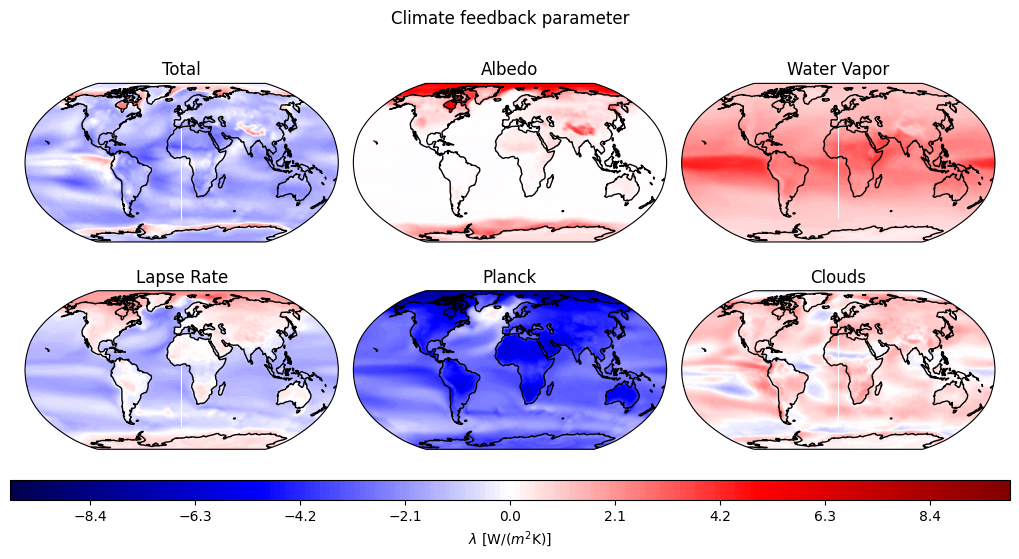

In [7]:
fig, axes = plt.subplots(2, 3,                         # define figure with cartopy
          subplot_kw={'projection': ccrs.Robinson()}, figsize=(10,5))
axflat = axes.flatten()

titles = ["Total", "Albedo", "Water Vapor", "Lapse Rate", "Planck", "Clouds"]
    
for idx, var in enumerate(feedbacks.data_vars):
    
    axflat[idx].set_title(titles[idx])
    annualmean = feedbacks[var].mean(dim={"time", "model"})
    axflat[idx].coastlines()
    im = axflat[idx].contourf(annualmean.lon, annualmean.lat, annualmean, cmap="seismic", transform=ccrs.PlateCarree(), levels=np.arange(-10,10.1, 0.1))

cbar_ax = fig.add_axes([0, 0, 1, 0.04])
fig.colorbar(im, cax=cbar_ax, orientation="horizontal", label="$\lambda$ [W/($m^2$K)]")
plt.suptitle('Climate feedback parameter')
plt.tight_layout()

### Task 5

Compare the model-mean feedback strengths for the respective feedbacks for summer,
winter and yearly mean, averaged over the Arctic (70◦ N – 90◦ N) and compare them
to the global mean (see Block et al. 2020, Fig. 6).

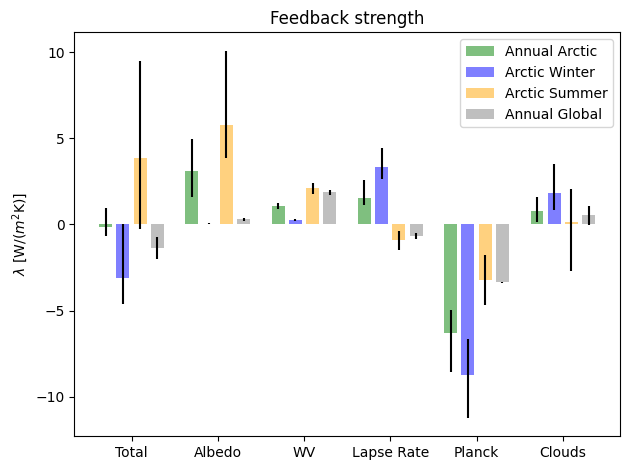

In [8]:
fig, ax = plt.subplots(1,1)

titles = ["Total", "Albedo", "WV", "Lapse Rate", "Planck", "Clouds"]

winter = [12,1,2]
summer = [6,7,8]

global_weights = np.cos(np.deg2rad(feedbacks.lat))
arctic_weights = xr.where(feedbacks.lat.values >= 70, global_weights, 0)

for idx, var in enumerate(feedbacks.data_vars):
    
    wi_mean = feedbacks[var].sel(time=winter).weighted(arctic_weights).mean(dim={"time", "model", "lat", "lon"}, skipna=True)
    su_mean = feedbacks[var].sel(time=summer).weighted(arctic_weights).mean(dim={"time", "model", "lat", "lon"}, skipna=True)
    an_mean = feedbacks[var].weighted(arctic_weights).mean(dim={"time", "model", "lat", "lon"}, skipna=True)
    gl_mean = feedbacks[var].weighted(global_weights).mean(dim={"time", "model", "lat", "lon"}, skipna=True)
    
    wi_models = feedbacks[var].sel(time=winter).weighted(arctic_weights).mean(dim={"time", "lat", "lon"}, skipna=True).values
    su_models = feedbacks[var].sel(time=summer).weighted(arctic_weights).mean(dim={"time", "lat", "lon"}, skipna=True).values
    an_models = feedbacks[var].weighted(arctic_weights).mean(dim={"time", "lat", "lon"}, skipna=True).values
    gl_models = feedbacks[var].weighted(global_weights).mean(dim={"time", "lat", "lon"}, skipna=True).values
    
    if idx == 0:
        ax.bar(idx-0.3, an_mean, width=0.15, color="green", label="Annual Arctic", alpha=0.5)
        ax.bar(idx-0.1, wi_mean, width=0.15, color="blue", label="Arctic Winter", alpha=0.5)
        ax.bar(idx+0.1, su_mean, width=0.15, color="orange", label="Arctic Summer", alpha=0.5)
        ax.bar(idx+0.3, gl_mean, width=0.15, color="grey", label="Annual Global", alpha=0.5)
    else:
        ax.bar(idx-0.3, an_mean, width=0.15, color="green", alpha=0.5)
        ax.bar(idx-0.1, wi_mean, width=0.15, color="blue", alpha=0.5)
        ax.bar(idx+0.1, su_mean, width=0.15, color="orange", alpha=0.5)
        ax.bar(idx+0.3, gl_mean, width=0.15, color="grey", alpha=0.5)
        
    
    ax.vlines(idx-0.3, ymin=np.min(an_models), ymax=np.max(an_models), color="black")
    ax.vlines(idx-0.1, ymin=np.min(wi_models), ymax=np.max(wi_models), color="black")
    ax.vlines(idx+0.1, ymin=np.min(su_models), ymax=np.max(su_models), color="black")
    ax.vlines(idx+0.3, ymin=np.min(gl_models), ymax=np.max(gl_models), color="black")
        
ax.legend()
ax.set_xticks(np.arange(0,6))
ax.set_xticklabels(titles)
ax.set_ylabel("$\lambda$ [W/($m^2$K)]")
ax.set_title('Feedback strength')
plt.tight_layout()

### Task 6

Warming contributions to Arctic Amplification:  WC = -local albedo feedback * local surface temperature change / local mean Planck feedback.

In [9]:
# create empty lists to append
loc_lambda_total = []
loc_lambda_A = []
loc_lambda_WV = []
loc_lambda_LR = []
loc_lambda_P = []
loc_lambda_C = []
loc_DTs = []
ERFs = []

for idx, model in enumerate(model_list):                                # loop over all models

    ds_picntrl = xr.open_dataset(f"{archive}{model}/{model}_"         +\
                                     "piControl_ymonmean.nc",               # load data from file for all models
                                     decode_times=False).assign_coords(     # and assign times as new coordinates
                                     time=times)                            # to make them comparable
    ds_piclim  = xr.open_dataset(f"{archive}{model}/{model}_piClim-"  +\
                                     "4xCO2_ymonmean.nc", 
                                     decode_times=False).assign_coords(
                                     time=times)
    ds_abrpt   = xr.open_dataset(f"{archive}{model}/{model}_abrupt-"  +\
                                     "4xCO2_ymonmean.nc", 
                                     decode_times=False).assign_coords(
                                     time=times)

    R_picntrl = ds_picntrl.rsdt - ds_picntrl.rsut - ds_picntrl.rlut     # calculate top-of-atmosphere radiation
    R_piclim  = ds_piclim.rsdt  - ds_piclim.rsut  - ds_piclim.rlut      # for control, 4xCO2 with fixed SST and
    R_abrpt   = ds_abrpt.rsdt   - ds_abrpt.rsut   - ds_abrpt.rlut       # 4xCO2 runs

    # -- total feedback
    ERF = R_piclim - R_picntrl
    ERFs.append(ERF)
    ERF_yr = ERF.mean(dim="time")
    Delta_R = R_abrpt - R_picntrl

    weights = np.cos(np.deg2rad(ds_picntrl.lat))
    Delta_Ts = (ds_abrpt.ts - ds_picntrl.ts).weighted(weights).mean(dim={"lat", "lon"})
    
    loc_Delta_Ts = ds_abrpt.ts - ds_picntrl.ts
    loc_lambda_total.append((Delta_R - ERF)/loc_Delta_Ts)
    loc_DTs.append(loc_Delta_Ts)

    # -- Albedo feedback
    toa_sw_out = ds_picntrl['rsutcs']
    toa_sw_in = ds_picntrl['rsdt']
    a_picntrl = toa_sw_out/toa_sw_in

    toa_sw_out = ds_abrpt['rsutcs']
    toa_sw_in = ds_abrpt['rsdt']
    a_abrpt = toa_sw_out/toa_sw_in

    Da = 100*(a_abrpt-a_picntrl)
    K_a = ds_krnl['K_a']
    DR_A = K_a*Da
    loc_lambda_A.append(DR_A/loc_Delta_Ts)

    # -- difference between te pressure levels
    plev = np.array(ds_krnl['p'])
    dp = np.diff(plev, axis=1, append=0)
    pstrat = 100*10**2+200*10**2* np.abs(ds_picntrl.lat)/90  # tropopause pressure mask
    pstrat_mask = np.broadcast_to(pstrat.values[np.newaxis,np.newaxis,:,np.newaxis], dp.shape) # reshape to fit
    dp_mask = np.where(plev>=pstrat_mask, dp, 0)
    dp_mask = - dp_mask/10000 # convert to 100hPa unit to match K unit (add minus b/c K is defined from toa)

    # -- temperature feedback
    K_Ts = ds_krnl['K_T_sfc']
    K_T = ds_krnl['K_T']
    D_Ts = ds_abrpt.ts - ds_picntrl.ts
    D_Ti = ds_abrpt.ta - ds_picntrl.ta
    DR_T = K_Ts*D_Ts + np.sum(K_T * D_Ti *dp_mask, axis=1)
    loc_lambda_T = DR_T/loc_Delta_Ts

    # -- Planck feedback
    DR_P = (K_Ts + np.sum(K_T * dp_mask, axis=1))*D_Ts
    loc_lambda_P.append(DR_P/loc_Delta_Ts)

    # -- lapse rate feedback
    DR_LR = DR_T-DR_P
    loc_lambda_LR.append(DR_LR/loc_Delta_Ts)

    # -- water vapor feedback
    Delta_lnq = np.log(ds_abrpt.hus) - np.log(ds_picntrl.hus)
    def qsat(T,p):
        """ T in K, p in Pa"""
        esat = 6.112 * np.exp((17.67 * (T - 273.15)) / ((T - 273.15) + 243.5))
        return (0.622*esat)/(p-(1-0.622)*esat)

    T = ds_picntrl.ta
    p = ds_krnl.p
    denominator = (np.log(qsat(T+0.1,p))-np.log(qsat(T, p)))/0.1

    Delta_lnT = Delta_lnq/denominator
    Delta_RT = np.sum(ds_krnl.K_wv * Delta_lnT * dp_mask, axis=1)
    loc_lambda_WV.append(Delta_RT / loc_Delta_Ts)

    #  -- cloud feedback 
    loc_lambda_C.append(loc_lambda_total[idx] - (loc_lambda_A[idx] + loc_lambda_WV[idx] + loc_lambda_LR[idx] + loc_lambda_P[idx]))
    
#loc_lambda_total = xr.concat(lambda_total, "model").assign_coords({"model": model_list}).rename("total_feedback")
loc_lambda_A = xr.concat(loc_lambda_A, "model").assign_coords({"model": model_list}).rename("local_albedo_feedback")
loc_lambda_WV = xr.concat(loc_lambda_WV, "model").assign_coords({"model": model_list}).rename("local_water_vapor_feedback")
loc_lambda_LR = xr.concat(loc_lambda_LR, "model").assign_coords({"model": model_list}).rename("local_lapse_rate_feedback")
loc_lambda_P = xr.concat(loc_lambda_P, "model").assign_coords({"model": model_list}).rename("local_planck_feedback")
loc_lambda_C = xr.concat(loc_lambda_C, "model").assign_coords({"model": model_list}).rename("local_cloud_feedback")
loc_delta_Ts = xr.concat(loc_DTs, "model").assign_coords({"model": model_list}).rename("local_delta_Ts")
ERFs = xr.concat(ERFs, "model").assign_coords({"model": model_list}).rename("ERF")

loc_feedbacks = xr.merge([loc_lambda_A, loc_lambda_WV, loc_lambda_LR, loc_lambda_P, loc_lambda_C, loc_delta_Ts, ERFs])

In [10]:
spat_loc_lambda_P = loc_feedbacks['local_planck_feedback'].weighted(global_weights).mean(dim={'lat', 'lon'})
dev_lambda_P = loc_feedbacks['local_planck_feedback'] - spat_loc_lambda_P

DTs_CO2 = - loc_feedbacks['ERF']/ spat_loc_lambda_P
DTs_P = - dev_lambda_P* loc_feedbacks['local_delta_Ts'] / spat_loc_lambda_P
DTs_WV = - loc_feedbacks['local_water_vapor_feedback']* loc_feedbacks['local_delta_Ts'] / spat_loc_lambda_P
DTs_A =  - loc_feedbacks['local_albedo_feedback']* loc_feedbacks['local_delta_Ts'] / spat_loc_lambda_P
DTs_C =  - loc_feedbacks['local_cloud_feedback']* loc_feedbacks['local_delta_Ts'] / spat_loc_lambda_P
DTs_LR =  - loc_feedbacks['local_lapse_rate_feedback']* loc_feedbacks['local_delta_Ts'] / spat_loc_lambda_P

loc_feedbacks['DTs_CO2']=DTs_CO2
loc_feedbacks['DTs_P']=DTs_P
loc_feedbacks['DTs_WV']=DTs_WV
loc_feedbacks['DTs_A']=DTs_A
loc_feedbacks['DTs_C']=DTs_C
loc_feedbacks['DTs_LR']=DTs_LR

loc_feedbacks

<xarray.Dataset>
Dimensions:                     (time: 12, lat: 144, lon: 192, model: 6)
Coordinates:
  * time                        (time) float32 1.0 2.0 3.0 ... 10.0 11.0 12.0
  * lat                         (lat) float32 -89.38 -88.12 ... 88.12 89.38
  * lon                         (lon) float32 0.9375 2.812 4.688 ... 357.2 359.1
  * model                       (model) <U13 'MPI-ESM1-2-LR' ... 'CESM2'
Data variables: (12/13)
    local_albedo_feedback       (model, time, lat, lon) float32 0.6225 ... nan
    local_water_vapor_feedback  (model, time, lat, lon) float64 0.9276 ... 0....
    local_lapse_rate_feedback   (model, time, lat, lon) float64 0.2418 ... 0....
    local_planck_feedback       (model, time, lat, lon) float64 -2.596 ... -2...
    local_cloud_feedback        (model, time, lat, lon) float64 0.0501 ... nan
    local_delta_Ts              (model, time, lat, lon) float32 6.322 ... 31.38
    ...                          ...
    DTs_CO2                     (model, time, lat, lon) float64 0.8326 ... 2.255
    DTs_P                       (model, time, lat, lon) float64 1.497 ... 9.06
    DTs_WV                      (model, time, lat, lon) float64 1.724 ... 0.5887
    DTs_A                       (model, time, lat, lon) float64 1.157 ... nan
    DTs_C                       (model, time, lat, lon) float64 0.09311 ... nan
    DTs_LR                      (model, time, lat, lon) float64 0.4495 ... 9.056

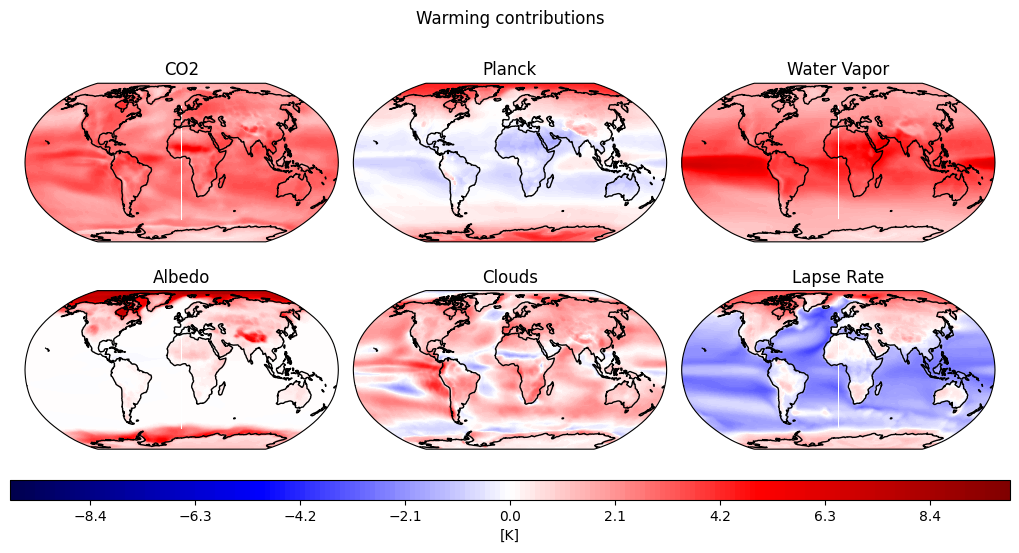

In [36]:
fig, axes = plt.subplots(2, 3,                         # define figure with cartopy
          subplot_kw={'projection': ccrs.Robinson()}, figsize=(10,5))
axflat = axes.flatten()

variables = ["DTs_CO2", "DTs_P", "DTs_WV", "DTs_A", "DTs_C", "DTs_LR"]
titles = ["CO2", "Planck", "Water Vapor", "Albedo", "Clouds", "Lapse Rate"]
    
for idx, var in enumerate(variables):
    
    axflat[idx].set_title(titles[idx])
    annualmean = loc_feedbacks[var].mean(dim={"time", "model"})
    axflat[idx].coastlines()
    im = axflat[idx].contourf(annualmean.lon, annualmean.lat, annualmean, cmap="seismic", transform=ccrs.PlateCarree(), levels=np.arange(-10,10.1, 0.1))

cbar_ax = fig.add_axes([0, 0, 1, 0.04])
fig.colorbar(im, cax=cbar_ax, orientation="horizontal", label="[K]")
plt.suptitle('Warming contributions')
plt.tight_layout()

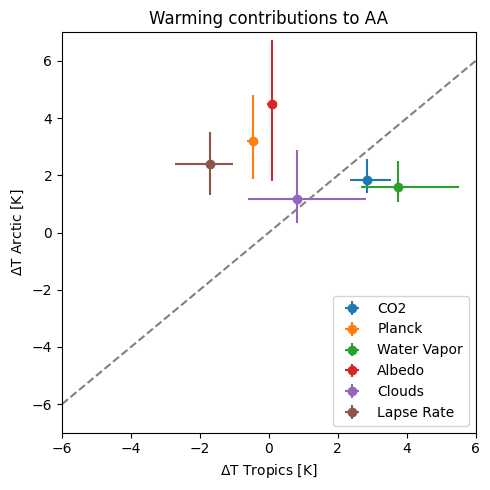

In [37]:
# Warming contributions to Arctic Amplification

arctic_weights = xr.where(feedbacks.lat.values >= 70, global_weights, 0)
tropics_weights = xr.where((feedbacks.lat.values <=30) & (feedbacks.lat.values >=-30), global_weights, 0)

fig, ax = plt.subplots(1, 1, figsize=(5,5))

variables = ["DTs_CO2", "DTs_P", "DTs_WV", "DTs_A", "DTs_C", "DTs_LR"]
titles = ["CO2", "Planck", "Water Vapor", "Albedo", "Clouds", "Lapse Rate"]
    
for idx, var in enumerate(variables):
    annualmean_tropics_models = loc_feedbacks[var].weighted(tropics_weights).mean(dim={"time", "lat", "lon"}, skipna=True)
    annualmean_arctic_models = loc_feedbacks[var].weighted(arctic_weights).mean(dim={"time", "lat", "lon"}, skipna=True)
    annualmean_tropics = loc_feedbacks[var].weighted(tropics_weights).mean(dim={"time", "model", "lat", "lon"}, skipna=True)
    annualmean_arctic = loc_feedbacks[var].weighted(arctic_weights).mean(dim={"time", "model", "lat", "lon"}, skipna=True)
    
    im = ax.errorbar(
        annualmean_tropics, 
        annualmean_arctic, 
        #xerr=[[3],[4]],
        #yerr=[[3],[4]],
        xerr=[[annualmean_tropics-np.min(annualmean_tropics_models.data)],[np.max(annualmean_tropics_models.data)-annualmean_tropics]], 
        yerr=[[annualmean_arctic-np.min(annualmean_arctic_models.data)],[np.max(annualmean_arctic_models.data)-annualmean_arctic]], 
        fmt='o',
        label=titles[idx],
    )

plt.title('Warming contributions to AA')
plt.xlabel('$\Delta$T Tropics [K]')
plt.ylabel('$\Delta$T Arctic [K]')
plt.xlim(-6,6)
plt.ylim(-7,7)
plt.plot(np.arange(-6,7,1), np.arange(-6,7,1), c='gray', ls='dashed')
plt.legend(loc='lower right')

plt.tight_layout()


## Task 7

How much do the feedbacks in each model contribute to Arctic Amplification?
AA factor is defined as the ratio of AA = $\frac{\Delta Ts_{Arctic}}{\Delta Ts_{Global}}$


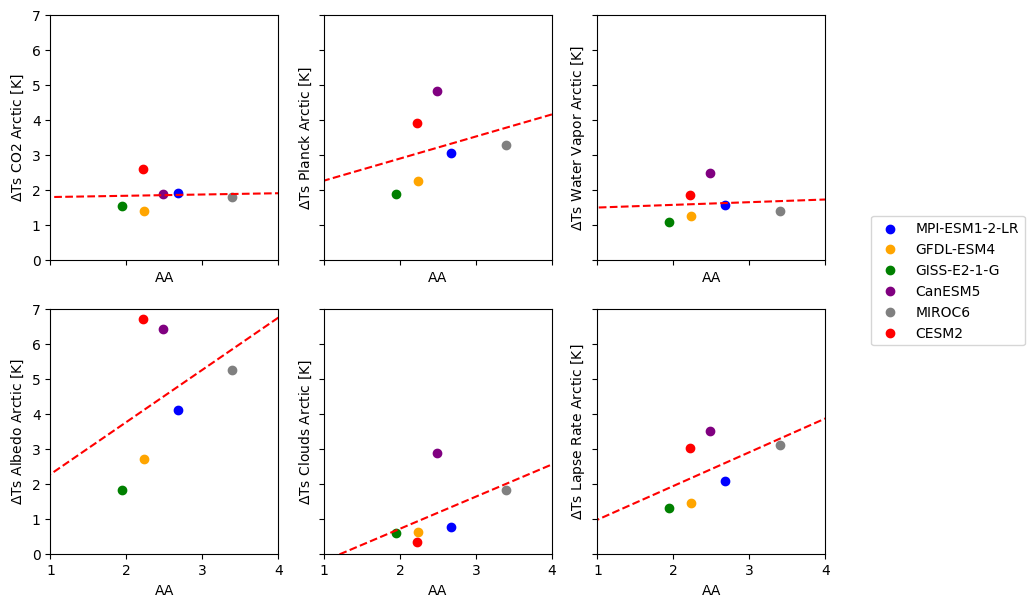

In [69]:
arctic_weights = xr.where(feedbacks.lat.values >= 70, global_weights, 0)


variables = ["DTs_CO2", "DTs_P", "DTs_WV", "DTs_A", "DTs_C", "DTs_LR"]
for idx, var in enumerate(variables):
    dTs_x_arctic = loc_feedbacks[var].weighted(arctic_weights).mean(dim={"time", "lat", "lon"}, skipna=True)
    dTs_x_global = loc_feedbacks[var].weighted(global_weights).mean(dim={"time", "lat", "lon"}, skipna=True)
    
    loc_feedbacks[var+'_arctic']=dTs_x_arctic
    loc_feedbacks[var+'_global']=dTs_x_global

loc_feedbacks['dTs_arctic']=loc_feedbacks.local_delta_Ts.weighted(arctic_weights).mean(dim={"time", "lat", "lon"}, skipna=True)
loc_feedbacks['dTs_global']=loc_feedbacks.local_delta_Ts.weighted(global_weights).mean(dim={"time", "lat", "lon"}, skipna=True)


# Model comparison Feedback contribution Arctic Amplification
fig, ax = plt.subplots(2 , 3, figsize=(10,7), sharex=True, sharey=True)
axflat = ax.flatten()

variables = ["DTs_CO2", "DTs_P", "DTs_WV", "DTs_A", "DTs_C", "DTs_LR"]
titles = ["CO2", "Planck", "Water Vapor", "Albedo", "Clouds", "Lapse Rate"]
colors = ['blue', 'orange', 'green', 'purple', 'gray', 'red']
models = loc_feedbacks.model.data

delta_ts_x = np.nan*np.zeros((6,6))
AA = np.nan*np.zeros((6,6))
for idx, var in enumerate(variables):
    for idy, model in enumerate(models):
        
        AA[idx][idy] = loc_feedbacks.sel(model=model)['dTs_arctic']/loc_feedbacks.sel(model=model)['dTs_global']
        delta_ts_x[idx][idy] = loc_feedbacks.sel(model=model)[var+'_arctic']
        im = axflat[idx].scatter(
            AA[idx][idy],
            delta_ts_x[idx][idy], 
            color=colors[idy],
            #xerr=[[3],[4]],
            #yerr=[[3],[4]],
            label=loc_feedbacks.model.data[idy],
        )
    
    #axflat[idx].plot(np.arange(-6,7,1), np.arange(-6,7,1), c='gray', ls='dashed')

    
    #axflat[idx].set_title(titles[idx])
    axflat[idx].set_ylabel(f'$\Delta$Ts {titles[idx]} Arctic [K]')
    axflat[idx].set_xlabel('AA')
    axflat[idx].set_xticks(np.arange(1,6,1))
    slope, inter  = np.polyfit(AA[idx,:], delta_ts_x[idx,:], 1)
    T = np.arange(0,5,1)

    axflat[idx].plot(T, slope*T+inter, c='red', linestyle="dashed") 
    #print(slope)
    #print(AA[idx,:])
#plt.suptitle(f'Model comparison of feedback contribution to Arctic Amplification')

plt.xlim(1,4)
plt.ylim(0,7)
plt.legend(loc = (1.2, 0.85))

#plt.tight_layout()
plt.savefig("model_comparison.png", dpi=300)

## Task 8
Geoengineering Arctic Sea Ice?

### Choose a model to work with
MPI-ESM1-2-LR

### Generate changed CO2 abrupt dataset 'ds_abrupt_geo'
- Change sea ice albedo in summer to winter extent
- Change surface temperature in the changed region to the mean value over sea ice in summer
- Change Temperature and Water vapour profiles in the changed regions to the mean profile over sea ice in summer


### Compute the contributions to Arctic warming from the different feedbacks for this changed model runs


### Compare feedback contributions in the geoengineered run to the non-geoengineered run

In [87]:
model = 'MPI-ESM1-2-LR'
ds_picntrl = xr.open_dataset(f"{archive}{model}/{model}_"         +\
                                 "piControl_ymonmean.nc",               # load data from file for all models
                                 decode_times=False).assign_coords(     # and assign times as new coordinates
                                 time=times)                            # to make them comparable
#ds_piclim  = xr.open_dataset(f"{archive}{model}/{model}_piClim-"  +\
#                                 "4xCO2_ymonmean.nc", 
#                                 decode_times=False).assign_coords(
#                                 time=times)
ds_abrpt   = xr.open_dataset(f"{archive}{model}/{model}_abrupt-"  +\
                                 "4xCO2_ymonmean.nc", 
                                 decode_times=False).assign_coords(
                                 time=times)

#R_picntrl = ds_picntrl.rsdt - ds_picntrl.rsut - ds_picntrl.rlut     # calculate top-of-atmosphere radiation
#R_piclim  = ds_piclim.rsdt  - ds_piclim.rsut  - ds_piclim.rlut      # for control, 4xCO2 with fixed SST and
#R_abrpt   = ds_abrpt.rsdt   - ds_abrpt.rsut   - ds_abrpt.rlut       # 4xCO2 runs

## Experiment: Change Albedo
Fix the TOA albedo to the January values

In [115]:
# create empty lists to append
#loc_lambda_total = []
#loc_lambda_A = []
#loc_lambda_WV = []
#loc_lambda_LR = []
#loc_lambda_P = []
#loc_lambda_C = []
#loc_DTs = []
#ERFs = []

model = 'MPI-ESM1-2-LR'

ds_picntrl = xr.open_dataset(f"{archive}{model}/{model}_"         +\
                                 "piControl_ymonmean.nc",               # load data from file for all models
                                 decode_times=False).assign_coords(     # and assign times as new coordinates
                                 time=times)                            # to make them comparable
ds_piclim  = xr.open_dataset(f"{archive}{model}/{model}_piClim-"  +\
                                 "4xCO2_ymonmean.nc", 
                                 decode_times=False).assign_coords(
                                 time=times)
ds_abrpt_geo   = xr.open_dataset(f"{archive}{model}/{model}_abrupt-"  +\
                                 "4xCO2_ymonmean.nc", 
                                 decode_times=False).assign_coords(
                                 time=times)



R_picntrl = ds_picntrl.rsdt - ds_picntrl.rsut - ds_picntrl.rlut     # calculate top-of-atmosphere radiation
R_piclim  = ds_piclim.rsdt  - ds_piclim.rsut  - ds_piclim.rlut      # for control, 4xCO2 with fixed SST and
R_abrpt   = ds_abrpt.rsdt   - ds_abrpt.rsut   - ds_abrpt.rlut       # 4xCO2 runs

# -- total feedback
ERF = R_piclim - R_picntrl
#ERFs.append(ERF)
ERF_yr = ERF.mean(dim="time")
Delta_R = R_abrpt - R_picntrl

weights = np.cos(np.deg2rad(ds_picntrl.lat))
Delta_Ts = (ds_abrpt.ts - ds_picntrl.ts).weighted(weights).mean(dim={"lat", "lon"})

loc_Delta_Ts = ds_abrpt.ts - ds_picntrl.ts
#loc_lambda_total.append((Delta_R - ERF)/loc_Delta_Ts)
#loc_DTs.append(loc_Delta_Ts)

# -- Albedo feedback
toa_sw_out = ds_picntrl['rsutcs']
toa_sw_in = ds_picntrl['rsdt']
a_picntrl = toa_sw_out/toa_sw_in

toa_sw_out = ds_abrpt['rsutcs']
toa_sw_in = ds_abrpt['rsdt']
a_abrpt = toa_sw_out/toa_sw_in
a_abrpt_march = a_abrpt.sel(time=3)
Da = 100*(a_abrpt_march.data[None,:,:]-a_picntrl)

K_a = ds_krnl['K_a']
DR_A = K_a*Da
loc_lambda_A_geo = DR_A/loc_Delta_Ts

# -- difference between te pressure levels
plev = np.array(ds_krnl['p'])
dp = np.diff(plev, axis=1, append=0)
pstrat = 100*10**2+200*10**2* np.abs(ds_picntrl.lat)/90  # tropopause pressure mask
pstrat_mask = np.broadcast_to(pstrat.values[np.newaxis,np.newaxis,:,np.newaxis], dp.shape) # reshape to fit
dp_mask = np.where(plev>=pstrat_mask, dp, 0)
dp_mask = - dp_mask/10000 # convert to 100hPa unit to match K unit (add minus b/c K is defined from toa)

# -- temperature feedback
K_Ts = ds_krnl['K_T_sfc']
K_T = ds_krnl['K_T']
D_Ts = ds_abrpt.ts - ds_picntrl.ts
D_Ti = ds_abrpt.ta - ds_picntrl.ta
DR_T = K_Ts*D_Ts + np.sum(K_T * D_Ti *dp_mask, axis=1)
#loc_lambda_T = DR_T/loc_Delta_Ts

# -- Planck feedback
DR_P = (K_Ts + np.sum(K_T * dp_mask, axis=1))*D_Ts
loc_lambda_P = DR_P/loc_Delta_Ts

# -- lapse rate feedback
DR_LR = DR_T-DR_P
#loc_lambda_LR.append(DR_LR/loc_Delta_Ts)

# -- water vapor feedback
Delta_lnq = np.log(ds_abrpt.hus) - np.log(ds_picntrl.hus)
def qsat(T,p):
    """ T in K, p in Pa"""
    esat = 6.112 * np.exp((17.67 * (T - 273.15)) / ((T - 273.15) + 243.5))
    return (0.622*esat)/(p-(1-0.622)*esat)

T = ds_picntrl.ta
p = ds_krnl.p
denominator = (np.log(qsat(T+0.1,p))-np.log(qsat(T, p)))/0.1

Delta_lnT = Delta_lnq/denominator
Delta_RT = np.sum(ds_krnl.K_wv * Delta_lnT * dp_mask, axis=1)
#loc_lambda_WV.append(Delta_RT / loc_Delta_Ts)

#  -- cloud feedback 
#loc_lambda_C.append(loc_lambda_total[idx] - (loc_lambda_A[idx] + loc_lambda_WV[idx] + loc_lambda_LR[idx] + loc_lambda_P[idx]))

##loc_lambda_total = xr.concat(lambda_total, "model").assign_coords({"model": model_list}).rename("total_feedback")
#loc_lambda_A = xr.concat(loc_lambda_A, "model").assign_coords({"model": model_list}).rename("local_albedo_feedback")
#loc_lambda_WV = xr.concat(loc_lambda_WV, "model").assign_coords({"model": model_list}).rename("local_water_vapor_feedback")
#loc_lambda_LR = xr.concat(loc_lambda_LR, "model").assign_coords({"model": model_list}).rename("local_lapse_rate_feedback")
#loc_lambda_P = xr.concat(loc_lambda_P, "model").assign_coords({"model": model_list}).rename("local_planck_feedback")
#loc_lambda_C = xr.concat(loc_lambda_C, "model").assign_coords({"model": model_list}).rename("local_cloud_feedback")
#loc_delta_Ts = xr.concat(loc_DTs, "model").assign_coords({"model": model_list}).rename("local_delta_Ts")
#ERFs = xr.concat(ERFs, "model").assign_coords({"model": model_list}).rename("ERF")
#
#loc_feedbacks = xr.merge([loc_lambda_A, loc_lambda_WV, loc_lambda_LR, loc_lambda_P, loc_lambda_C, loc_delta_Ts, ERFs])

In [116]:
spat_loc_lambda_P = loc_lambda_P.weighted(global_weights).mean(dim={'lat', 'lon'})
#dev_lambda_P = loc_feedbacks['local_planck_feedback'] - spat_loc_lambda_P

#DTs_CO2 = - loc_feedbacks['ERF']/ spat_loc_lambda_P
#DTs_P = - dev_lambda_P* loc_feedbacks['local_delta_Ts'] / spat_loc_lambda_P
#DTs_WV = - loc_feedbacks['local_water_vapor_feedback']* loc_feedbacks['local_delta_Ts'] / spat_loc_lambda_P
DTs_A =  - loc_lambda_A_geo * loc_Delta_Ts / spat_loc_lambda_P
#DTs_C =  - loc_feedbacks['local_cloud_feedback']* loc_feedbacks['local_delta_Ts'] / spat_loc_lambda_P
#DTs_LR =  - loc_feedbacks['local_lapse_rate_feedback']* loc_feedbacks['local_delta_Ts'] / spat_loc_lambda_P

#loc_feedbacks['DTs_CO2']=DTs_CO2
#loc_feedbacks['DTs_P']=DTs_P
#loc_feedbacks['DTs_WV']=DTs_WV
#loc_feedbacks['DTs_A']=DTs_A
#loc_feedbacks['DTs_C']=DTs_C
#loc_feedbacks['DTs_LR']=DTs_LR

#loc_feedbacks

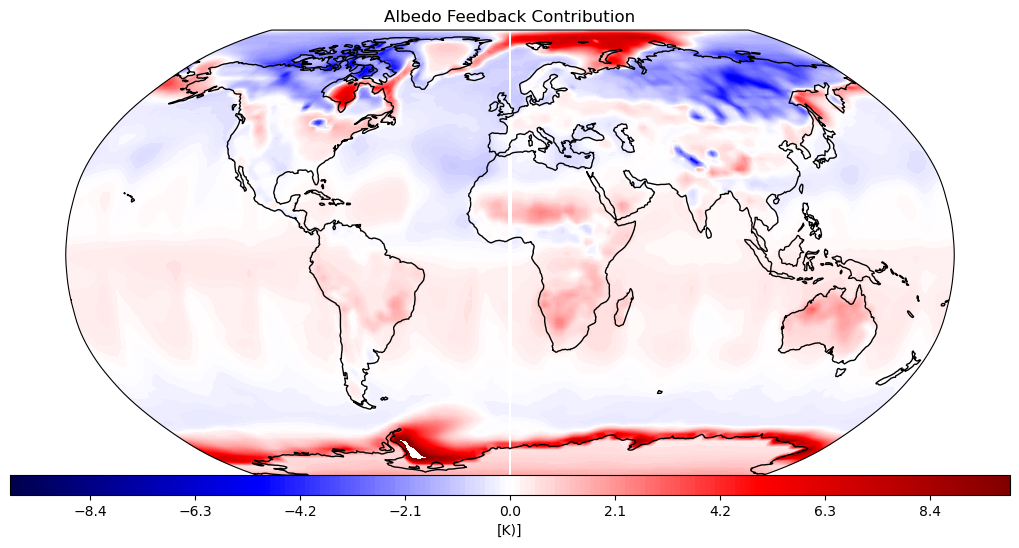

In [119]:
fig, ax = plt.subplots(1,1,                         # define figure with cartopy
          subplot_kw={'projection': ccrs.Robinson()}, figsize=(10,5))

    
annualmean = DTs_A.mean(dim={"time"})
ax.coastlines()
im = ax.contourf(annualmean.lon, annualmean.lat, annualmean, cmap="seismic", transform=ccrs.PlateCarree(), levels=np.arange(-10,10.1, 0.1))

cbar_ax = fig.add_axes([0, 0, 1, 0.04])
fig.colorbar(im, cax=cbar_ax, orientation="horizontal", label="[K)]")
ax.set_title('Albedo Feedback Contribution')
plt.tight_layout()

- Pick a gridbox, where we have no sea ice in the CO2 abrupt run but we have sea ice in the CO2 abrupt geo run.
- Compute $\Delta R_{4x\alpha} - \Delta R_{4x,\alpha, geo}$ to know, what energy we are saving by having more ice / higher albedo
    - some value in Wm-2
    - Compute the energy saved in one year
- Compute the energy released as latent heat for freezing the ice
    - Assume we want to have 10$\,$m thickness increase on that gridbox
    - Compute